# 0.0 Import Libraries

In [36]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

import math 
import inflection
import datetime

from IPython.display import Image

# 0.1 Load Data

In [2]:
# reading data
df_sales_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store.csv', low_memory= False )

# merging datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 0.2 Functions

In [3]:
# rename columns to snakecase style
def rename_columns(dataframe):
    df = dataframe.copy()

    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new
    
    return df

# 1.0 Data Descriptive Analysis

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
df1 = rename_columns( df1 )
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [6]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [7]:
# list data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
# number of rows with NA values by column
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance 
# competition_distance with NA values means "no competitor around". 
# Set max value mutiplied by 3 in the null rows

max_value = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: max_value*3 if math.isnan( x ) else x )

print(f'Old Max Value of competition distance: { max_value } ' )
print(f'New Max Value of competition distance: { df1["competition_distance"].max() } ' )


Old Max Value of competition distance: 75860.0 
New Max Value of competition distance: 227580.0 


In [11]:
# competition_open_since_month and competition_open_since_year 
# Set month and year of sale as default value

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year']  = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )   else x['competition_open_since_year'], axis=1 )

In [12]:
# promo2_since_week  and promo2_since_year
# Set month and year of sale as default value

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [13]:
# promo_interval  

# first, create a new column(month_map) with the month of sale  
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['promo_interval'].fillna( 0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )

# second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 


df1.sample(5).T

,378023,81680,978632,667304,835717
store,549,286,448,205,253
day_of_week,6,2,1,7,3
date,2014-08-02 00:00:00,2015-05-19 00:00:00,2013-02-04 00:00:00,2013-11-10 00:00:00,2013-06-12 00:00:00
sales,3498,4757,12942,0,3971
customers,342,412,989,0,568
open,1,1,1,0,1
promo,0,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,a,a


## 1.6 Change Types

In [14]:
# change data types from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [15]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

df_cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
64990,0,c,c,"Mar,Jun,Sept,Dec",Jun
735165,0,a,c,"Jan,Apr,Jul,Oct",Sep


### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [18]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

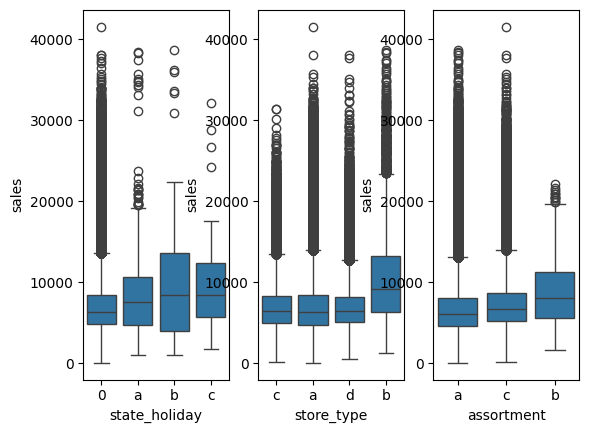

In [19]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=df1_aux)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=df1_aux )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=df1_aux )


# 2.0 Feature Engineering

In [78]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map

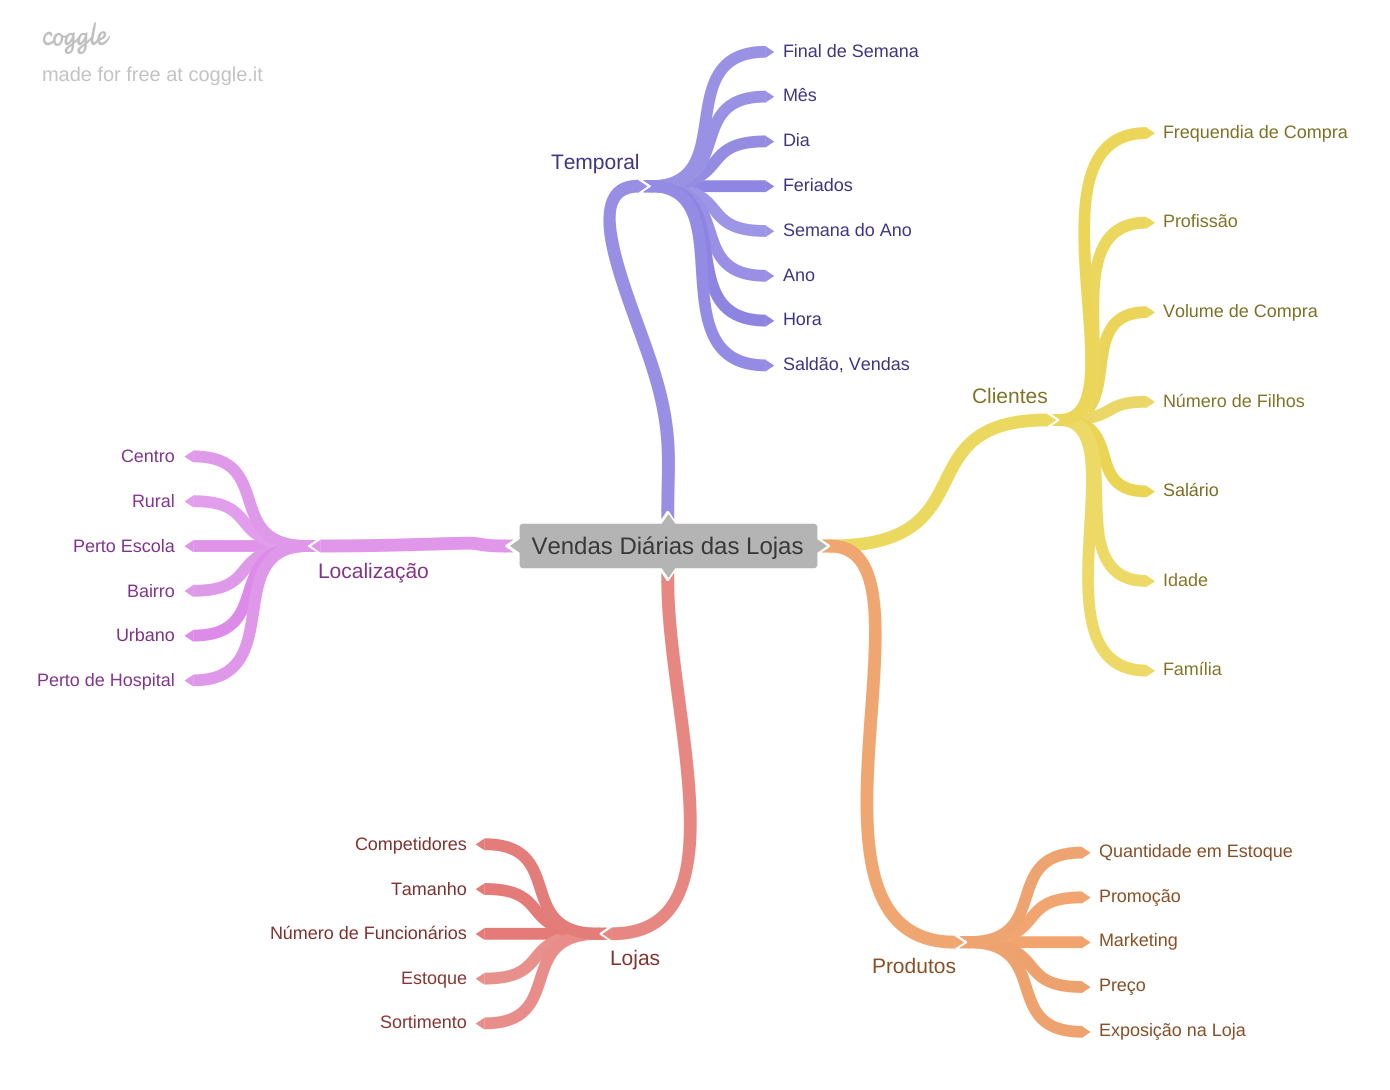

In [79]:
Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

### 2.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 2.4 Create Features

### 2.4.1 From date column

In [80]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

# year week
df2['year_week'] = df2.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

df2[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
694966,2013-10-17,2013,10,17,42,2013-42
482620,2014-04-25,2014,4,25,17,2014-17
305223,2014-10-19,2014,10,19,42,2014-42
429530,2014-06-12,2014,6,12,24,2014-24
857610,2013-05-24,2013,5,24,21,2013-21


### 2.4.2 From competition_open_since columns

In [81]:
df2['competition_since']      = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = df2.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
242450,2014-12-25,2013,9,2013-09-01,16
218082,2015-01-17,2015,1,2015-01-01,0
703841,2013-10-09,2012,9,2012-09-01,13
562054,2014-02-13,2014,2,2014-02-01,0
206703,2015-01-27,2005,7,2005-07-01,116


### 2.4.3 From promo2_since columns

In [82]:
df2['promo2_since']     = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo2_since']     = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo2_time_week'] = df2.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

df2[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
794641,2013,29,2013-07-15,2013-07-19,0
517025,2010,13,2010-03-22,2014-03-25,209
507339,2014,14,2014-03-31,2014-04-03,0
554671,2014,8,2014-02-17,2014-02-19,0
404289,2014,27,2014-06-30,2014-07-05,0


### 2.4.4 From assorment column

In [83]:
#  describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )
df2['assortment'].sample(5)

,assortment,assortment_level
1017170,a,basic
327644,a,basic
75528,a,basic
120633,a,basic
633398,a,basic


### 2.4.5 From state_holiday column

In [84]:
#StateHoliday - indicates a state holiday. 
#Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'None' )
df2['state_holiday'].sample(5)


,state_holiday,state_holiday_name
659603,0,None
336052,0,None
798406,0,None
508280,0,None
88251,0,None


## 2.5 Filtering Variables

### 2.5.1 Filtering Lines

In [86]:
# remove lines where there are no sales 
df2 = df2[ ( df2['open'] != 0 ) & ( df2['sales'] > 0 ) ]
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,assortment_level,state_holiday_name
989880,546,5,2013-01-25,13264,1554,1,1,0,0,a,...,1,25,4,2013-4,2005-01-01,98,2013-01-21,0,basic,None
685413,474,5,2013-10-25,7808,810,1,1,0,1,c,...,10,25,43,2013-43,2013-10-01,0,2011-03-28,134,basic,None
508121,467,3,2014-04-02,13777,1625,1,1,0,0,a,...,4,2,14,2014-14,2008-04-01,73,2014-03-31,0,extended,None
1014127,263,4,2013-01-03,1890,220,1,0,0,1,a,...,1,3,1,2013-1,2013-05-01,-4,2014-09-29,-91,extended,None
801209,310,6,2013-07-13,6989,614,1,0,0,0,a,...,7,13,28,2013-28,2013-07-01,0,2014-03-03,-34,extended,None


### 2.5.2 Filtering Columns

In [89]:
# customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição. 
# open -> Se a loja está aberta ou não. Quando está fechada não há vendas, ou seja, devem ser consideradas apenas as linhas com loja aberta ( open != 0 )
# sales -> Valor total em vendas. Quando não há vendas desconsiderar linhas ( sales > 0 )
# colunas que foram criadas apenas para auxiliar a geração de outras também devem ser excluídas. Ex: promo_interval, month_map

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df2 = df2.drop( cols_drop, axis=1 )
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week',
       'assortment_level', 'state_holiday_name'],
      dtype='object')